In [ ]:
!pip install -U lightautoml

In [71]:
# Standard python libraries
import os

# Installed libraries
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Imports from our package
from lightautoml.tasks import Task
from lightautoml.addons.autots.base import AutoTS
from lightautoml.dataset.roles import DatetimeRole
# from lightautoml.automl.base import AutoML
# from lightautoml.ml_algo.boost_cb import BoostCB
# from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
# from lightautoml.pipelines.features.lgb_pipeline import LGBSeqSimpleFeatures
# from lightautoml.pipelines.features.linear_pipeline import LinearTrendFeatures
# from lightautoml.pipelines.ml.base import MLPipeline
# from lightautoml.reader.base import DictToPandasSeqReader
# from lightautoml.automl.blend import WeightedBlender
# from lightautoml.ml_algo.random_forest import RandomForestSklearn

# Disable warnings

import warnings
warnings.filterwarnings("ignore")

In [213]:

class LamaTSA:
    
    def __init__(self, store_id, item_id, period='7'):
        print("preprocessing loaded data...")
        self.store_id = f"STORE_{store_id}" if isinstance(store_id, int) or store_id.isnumeric() else store_id
        self.item_id = f"{self.store_id}_{item_id}" if isinstance(item_id, int) or item_id.isnumeric() else item_id
        
        periods = {"w": 7, "m": 30, "q": 90}        
        self.period = periods.get(period)
        if not self.period:
            raise ValueError(f'Incorrect period value: {period}\nSupported values: "w" - week, "m" - month, "q" - quarter')
        
        print("LamaTSA init complete!")

    def load_data(self, sales, dates, prices) -> pd.DataFrame:
        sales = pd.read_csv(sales)
        dates = pd.read_csv(dates)
        prices = pd.read_csv(prices)
        
        df = pd.merge(sales, dates, on='date_id')
        df = pd.merge(df, prices, on=['store_id', 'item_id', 'wm_yr_wk'])
        
        df = self.preprocess_data(df)
        return df

        
    def preprocess_data(self, df) -> pd.DataFrame:
        df['date'] = pd.to_datetime(df['date'])
        df = df.loc[df['store_id'] == self.store_id, ['item_id', 'date', 'cnt']]
        df = df.sort_values(by=['date']).reset_index(drop=True)
        # fill empty periods?

        print(f"data shape: {df.shape}\nselected class count: {df.loc[df.item_id == self.item_id].shape[0]}")
        return df
    
    # def split_train_test(self):
    #     test_start = self.df[self.df['item_id'] == self.item_id]['date'].values[-self.period]   # select item_id simple backtest
    #     train = self.df[self.df['date'] < test_start].copy()
    #     test = self.df[self.df['date'] >= test_start].copy()
    #     return train, test
        
    def define_training_task(self):
        
        # define task
        # "multi:reg": ["mae", "mse"],
        task = Task("multi:reg", greater_is_better=False, metric="mae", loss="mae")
        
        # configure model
        seq_params = {
            "seq0": {
                "case": "next_values",                  
                "params": {
                    "n_target": self.period,                
                    "history": self.period,                              
                    "step": 1, 
                    "from_last": True,
                    "test_last": True
                }
            }
        }
        
        transformers_params = {
            "lag_features": 30,       # 
            "lag_time_features": 30,  # 
        }
        
        automl = AutoTS(
            task,
            reader_params = {
                "seq_params": seq_params
            },
            time_series_trend_params={
                "trend": False,
            },
            time_series_pipeline_params=transformers_params
        )
        return automl
        
    def train_model(self, train_dataset, verbose=4):
        # load dataset
        univariate_train = train_dataset[train_dataset['item_id'] == self.item_id].drop("item_id", axis=1)
                
        # define roles
        univariate_roles = {
           "target": 'cnt',
           DatetimeRole(seasonality=('d', 'm', 'wd'), base_date=True): 'date',  # + y ?
        }
        
        # train model        
        model = self.define_training_task()
        univariate_train_pred, _ = model.fit_predict(univariate_train, univariate_roles, verbose=verbose)
        
        return model

    def eval_model(self, model, train_dataset, test_dataset):
        train_dataset = train_dataset[train_dataset['item_id'] == self.item_id].drop("item_id", axis=1)
        test_dataset = test_dataset[(test_dataset['item_id'] == self.item_id)].drop("item_id", axis=1)[:self.period]
        
        fcst, _ = model.predict(train_dataset)
        # print(f'forecast {(len(fcst))}: {fcst};\ntest size: {len(test_dataset.cnt.values)} {test_dataset}')
        
        mae = mean_absolute_error(test_dataset.cnt.values, fcst)
        print(f"MAE: {mae}")      
        
        # plot predictions
        fig = plt.figure(figsize=(13, 5))
        last_N = min(len(train_dataset), 120)  # historical data
        plt.plot(
            train_dataset['date'][-last_N:], 
            train_dataset['cnt'][-last_N:], 
            c="#003865", 
            label="train"
        )
        plt.plot(
            test_dataset['date'], 
            test_dataset['cnt'], 
            c="#EF5B0C", 
            label="test", 
            marker="o", 
            markersize=4
        )
        plt.plot(
            test_dataset['date'], 
            fcst, 
            c="#3CCF4E", 
            label="forecast", 
            marker="o", 
            markersize=4
        )

        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title(f"Train, test and forecasts of LightAutoML for product_id {self.item_id}")
        plt.legend()        
        return fig, mae
        
    def save_model(self, model, path):
        joblib.dump(model, path)
        return path
        
    def load_model(self, path):
        if not os.path.exists(path):
            raise ValueError("path to model not found!")
        
        try:
            model = joblib.load(path)
            print(f'model {path} loaded successfully')
        except Exception as e:
            print(f'Error loading model: {e}')
            return 0
        return model

    def predict(self, model, pred_df):        
        pred = pred_df[pred_df['item_id'] == self.item_id].drop("item_id", axis=1)
        fcst, _ = model.predict(pred)

        print(fcst, "\n")
        print(f"MAE: {mean_absolute_error(pred.cnt.values, fcst)}")
        return fcst
        

In [214]:
i = LamaTSA(
    store_id='2',  # selected store
    item_id='586',  # selected item
    period='q'  # w / m / q
)

train_df = i.load_data(
    sales="data/shop_sales.csv", 
    dates="data/shop_sales_dates.csv", 
    prices="data/shop_sales_prices.csv"
)

test_df = i.load_data(
    sales="data/shop_sales_test.csv", 
    dates="data/shop_sales_dates_test.csv", 
    prices="data/shop_sales_prices_test.csv"
)


preprocessing loaded data...
LamaTSA init complete!
data shape: (25864, 3)
selected class count: 1819
data shape: (1410, 3)
selected class count: 94


In [210]:
model = i.train_model(train_df)

multi:reg isn`t supported in lgb
[12:59:36] CatBoost supports only MultiRMSE metric and loss for multi:reg task.
[12:59:36] Stdout logging level is DEBUG.
[12:59:36] Task: multi:reg

[12:59:36] Start automl preset with listed constraints:
[12:59:36] - time: 3600.00 seconds
[12:59:36] - CPU: 4 cores
[12:59:36] - memory: 16 GB

[12:59:36] Layer 1 train process start. Time left 3599.97 secs
[12:59:36] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[12:59:36] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0, 'criterion': 'squared_error'}
[12:59:36] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[12:59:37] Score for RF model: -11.782743
[12:59:37] ===== Start working with fold 1 for Lvl_0_

In [211]:
i.save_model(model, 'models/model_f_q_586_mae.pkl')

'models/model_f_q_586_mae.pkl'

In [207]:
model = i.load_model('modelsmodel_f_q_586_mae.pkl')

model model_f_w_586_mae.pkl loaded successfully


MAE: 8.833949618869358


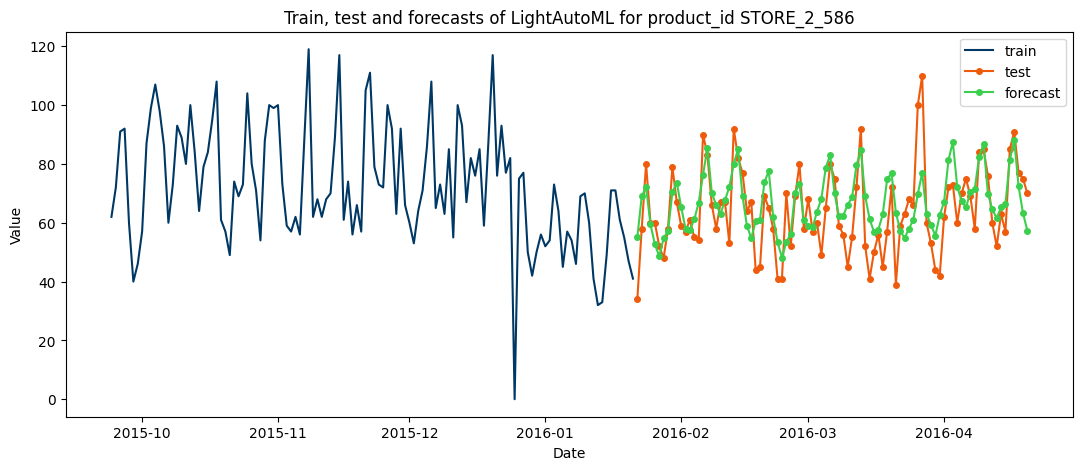

In [215]:
fig, mae = i.eval_model(model, train_df, test_df)